In [4]:
pip install lifelines

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats.distributions as dist
import seaborn as sns
 
from lifelines.fitters.coxph_fitter import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
from lifelines import KaplanMeierFitter

C:\Users\jonathan\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\jonathan\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# 1. Load Data and Clean

### 1.1 Load

In [2]:
df = pd.read_parquet('full_table.parquet')
df.head()

personid                           encounterid  \
0  000946f4-8ed9-4086-949d-8058fd7f7e4f  88d73329-83ac-4eb6-9329-6efe055c7a9d   
1  000a569a-5d0d-40e0-b620-fdcf8e1ac9ae  9171c764-e306-4870-ba92-4982094fc59c   
2  000b03a4-8ff0-47e5-80a6-4e87aa66dcd4  6c184f98-65ff-42d0-9d90-2a63e75df024   
3  000f27f5-9768-42ae-85f4-cc339dbc642a  24f99422-3611-48bb-a2d2-bdb767ad8a6f   
4  000f27f5-9768-42ae-85f4-cc339dbc642a  85384f2c-f3cd-46ed-bc91-6d0356d5c4ad   

   MDRO1  MDRO2         servicedate       dischargedate        LOS        DOD  \
0    0.0    0.0 2020-09-11 22:04:00 2020-10-08 00:30:00  26.101389 2020-10-07   
1    0.0    0.0 2021-06-05 03:27:00 2021-06-10 23:34:00   5.838194        NaT   
2    0.0    0.0 2021-07-01 07:28:44 2021-07-08 23:10:00   7.653657        NaT   
3    1.0    1.0 2016-01-10 08:56:00 2016-02-04 00:10:00  24.634722        NaT   
4    0.0    0.0 2015-12-07 18:13:00 2015-12-16 23:43:00   9.229167        NaT   

   Mortality  time_to_death_timestamp  ...  CCI       CCI_group  MELDi  MELD  \
0        1.0                25.080556  ...    3    1st quartile    NaN   NaN   
1        0.0                      NaN  ...    7    4th quartile    NaN   NaN   
2        0.0                      NaN  ...    6  third quartile    7.0   7.0   
3        0.0                      NaN  ...    3    1st quartile    NaN   NaN   
4        0.0                      NaN  ...    3    1st quartile    NaN   NaN   

     MELD_group  cp_pro_rated  cp_original  ACLF  hospice  nosocomial  
0          None     15.000000          NaN   3.0        0           0  
1          None      8.333333          NaN   3.0        0           0  
2  1st quartile      8.750000          NaN   3.0        0           0  
3          None     11.666667          NaN   3.0        0           0  
4          None     11.666667          NaN   3.0        0           0  

[5 rows x 75 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12570 entries, 0 to 12569
Data columns (total 75 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   personid                 12570 non-null  object        
 1   encounterid              12570 non-null  object        
 2   MDRO1                    12570 non-null  float64       
 3   MDRO2                    12570 non-null  float64       
 4   servicedate              12570 non-null  datetime64[ns]
 5   dischargedate            12570 non-null  datetime64[ns]
 6   LOS                      12570 non-null  float64       
 7   DOD                      2229 non-null   datetime64[ns]
 8   Mortality                12570 non-null  float64       
 9   time_to_death_timestamp  2229 non-null   float64       
 10  time_to_death_date       2229 non-null   float64       
 11  ALB_diff_hour            12570 non-null  float64       
 12  albumin                  12570 n

In [4]:
df.columns

Index(['personid', 'encounterid', 'MDRO1', 'MDRO2', 'servicedate',
       'dischargedate', 'LOS', 'DOD', 'Mortality', 'time_to_death_timestamp',
       'time_to_death_date', 'ALB_diff_hour', 'albumin', 'ICU', 'ICU_LOS',
       'ICU_Mortality', 'Jaundice', 'AKI', 'tenant', 'Index_Year', 'HRS', 'HE',
       'class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7',
       'class8', 'class9', 'class10', 'class11', 'class12', 'class13',
       'class14', 'class15', 'class16', 'class17', 'class18', 'class19',
       'class20', 'ABX_diff_hour', 'ALB_Dose', 'ALB_Dose_Count', 'DOB', 'Age',
       'Age_Group', 'Gender', 'Race', 'financialclass', 'Payor', 'zip_code',
       'bed_size', 'speciality', 'segment', 'Region', 'Teaching',
       'scr_enc_value', 'scr_90_value', 'bun_enc_value', 'bun_90_value',
       'bili_enc_value', 'bili_90_value', 'MAP', 'CCI', 'CCI_group', 'MELDi',
       'MELD', 'MELD_group', 'cp_pro_rated', 'cp_original', 'ACLF', 'hospice',
       'nosocomial'],
     

### 1.2 Select Variables of interest

In [5]:
df['Region'].value_counts()

West         7277
Northeast    1942
South        1825
Midwest      1526
Name: Region, dtype: int64

In [6]:
df_2 = df[['personid', 'encounterid', 'MDRO1', 'LOS', 'Mortality', 'time_to_death_timestamp', 'time_to_death_date', 'albumin',
           'ICU', 'AKI', 'Region', 'bed_size', 'tenant', 'Index_Year', 'HRS', 'HE', 'Age', 'Age_Group', 'Gender', 'Race',
           'Payor','bed_size', 'MELD', 'cp_pro_rated']]
df_2.head()

personid                           encounterid  \
0  000946f4-8ed9-4086-949d-8058fd7f7e4f  88d73329-83ac-4eb6-9329-6efe055c7a9d   
1  000a569a-5d0d-40e0-b620-fdcf8e1ac9ae  9171c764-e306-4870-ba92-4982094fc59c   
2  000b03a4-8ff0-47e5-80a6-4e87aa66dcd4  6c184f98-65ff-42d0-9d90-2a63e75df024   
3  000f27f5-9768-42ae-85f4-cc339dbc642a  24f99422-3611-48bb-a2d2-bdb767ad8a6f   
4  000f27f5-9768-42ae-85f4-cc339dbc642a  85384f2c-f3cd-46ed-bc91-6d0356d5c4ad   

   MDRO1        LOS  Mortality  time_to_death_timestamp  time_to_death_date  \
0    0.0  26.101389        1.0                25.080556                26.0   
1    0.0   5.838194        0.0                      NaN                 NaN   
2    0.0   7.653657        0.0                      NaN                 NaN   
3    1.0  24.634722        0.0                      NaN                 NaN   
4    0.0   9.229167        0.0                      NaN                 NaN   

   albumin  ICU  AKI  ... HRS HE   Age  Age_Group  Gender   Race     Payor  \
0        1  1.0  1.0  ...   0  0  36.0        1.0    Male  White      Self   
1        1  0.0  0.0  ...   1  0  44.0        1.0    Male  White   Unknown   
2        0  0.0  1.0  ...   0  0  70.0        4.0  Female  White  Medicare   
3        1  0.0  0.0  ...   0  0  50.0        2.0    Male  White  Medicaid   
4        1  0.0  0.0  ...   0  0  50.0        2.0    Male  White  Medicaid   

   bed_size MELD cp_pro_rated  
0    >=1000  NaN    15.000000  
1    >=1000  NaN     8.333333  
2   300-499  7.0     8.750000  
3    >=1000  NaN    11.666667  
4    >=1000  NaN    11.666667  

[5 rows x 24 columns]

In [7]:
df_2.shape

(12570, 24)

### 1.3 Drop Missing Rows

In [8]:
df_2 = df_2.loc[df_2['MELD'].notna()]
df_2.head()

personid                           encounterid  \
2  000b03a4-8ff0-47e5-80a6-4e87aa66dcd4  6c184f98-65ff-42d0-9d90-2a63e75df024   
6  00130c65-439d-40bd-b7f5-b7976dd91e5f  be11dd64-f5df-4d80-ab9f-bd57c4d79fb6   
7  0017bb37-317e-41a6-bef7-01b7840fa845  bf6e4e08-dccc-4004-8749-6d9fb4e4f756   
8  001c94ae-d5be-4f84-be44-0555cf68425c  1d0ba46e-6c8d-49a6-9631-1ff0cd301d30   
9  001ef405-5d5f-4625-9836-7a2672f12114  2f0df976-3da1-414e-9d68-f18baeebfa5d   

   MDRO1       LOS  Mortality  time_to_death_timestamp  time_to_death_date  \
2    0.0  7.653657        0.0                      NaN                 NaN   
6    0.0  6.038889        0.0                      NaN                 NaN   
7    0.0  2.626389        1.0                 1.713194                 2.0   
8    0.0  3.097917        0.0                      NaN                 NaN   
9    0.0  4.181250        0.0                      NaN                 NaN   

   albumin  ICU  AKI  ... HRS HE   Age  Age_Group  Gender     Race     Payor  \
2        0  0.0  1.0  ...   0  0  70.0        4.0  Female    White  Medicare   
6        1  0.0  1.0  ...   1  0  71.0        4.0    Male    White  Medicare   
7        1  0.0  1.0  ...   0  0  55.0        2.0  Female    White  Medicaid   
8        1  0.0  1.0  ...   0  0  60.0        3.0  Female    Black  Medicaid   
9        1  0.0  0.0  ...   0  0  48.0        1.0    Male  Unknown   Unknown   

   bed_size    MELD cp_pro_rated  
2   300-499   7.000         8.75  
6    >=1000  27.848        10.00  
7    >=1000   9.000         6.00  
8    >=1000   6.000         8.75  
9   500-999  35.079        11.00  

[5 rows x 24 columns]

In [9]:
df_2.shape

(9698, 24)

### 1.4 Clean Variables

#### Child-Pugh

In [10]:
df_2['cp_class'] = np.where(df_2['cp_pro_rated']<7.0, 1,
                   np.where((df_2['cp_pro_rated']>=7.0)&(df_2['cp_pro_rated']<10.0), 2, 3))
df_2.head()

personid                           encounterid  \
2  000b03a4-8ff0-47e5-80a6-4e87aa66dcd4  6c184f98-65ff-42d0-9d90-2a63e75df024   
6  00130c65-439d-40bd-b7f5-b7976dd91e5f  be11dd64-f5df-4d80-ab9f-bd57c4d79fb6   
7  0017bb37-317e-41a6-bef7-01b7840fa845  bf6e4e08-dccc-4004-8749-6d9fb4e4f756   
8  001c94ae-d5be-4f84-be44-0555cf68425c  1d0ba46e-6c8d-49a6-9631-1ff0cd301d30   
9  001ef405-5d5f-4625-9836-7a2672f12114  2f0df976-3da1-414e-9d68-f18baeebfa5d   

   MDRO1       LOS  Mortality  time_to_death_timestamp  time_to_death_date  \
2    0.0  7.653657        0.0                      NaN                 NaN   
6    0.0  6.038889        0.0                      NaN                 NaN   
7    0.0  2.626389        1.0                 1.713194                 2.0   
8    0.0  3.097917        0.0                      NaN                 NaN   
9    0.0  4.181250        0.0                      NaN                 NaN   

   albumin  ICU  AKI  ... HE   Age  Age_Group  Gender     Race     Payor  \
2        0  0.0  1.0  ...  0  70.0        4.0  Female    White  Medicare   
6        1  0.0  1.0  ...  0  71.0        4.0    Male    White  Medicare   
7        1  0.0  1.0  ...  0  55.0        2.0  Female    White  Medicaid   
8        1  0.0  1.0  ...  0  60.0        3.0  Female    Black  Medicaid   
9        1  0.0  0.0  ...  0  48.0        1.0    Male  Unknown   Unknown   

   bed_size    MELD cp_pro_rated cp_class  
2   300-499   7.000         8.75        2  
6    >=1000  27.848        10.00        3  
7    >=1000   9.000         6.00        1  
8    >=1000   6.000         8.75        2  
9   500-999  35.079        11.00        3  

[5 rows x 25 columns]

In [11]:
df_2.shape

(9698, 25)

#### MELD

In [12]:
df_2['MELD_group'] = pd.qcut(df_2['MELD'], q=3, labels=['Tertile 1', 'Tertile 2', 'Tertile 3'])
df_2.head()

personid                           encounterid  \
2  000b03a4-8ff0-47e5-80a6-4e87aa66dcd4  6c184f98-65ff-42d0-9d90-2a63e75df024   
6  00130c65-439d-40bd-b7f5-b7976dd91e5f  be11dd64-f5df-4d80-ab9f-bd57c4d79fb6   
7  0017bb37-317e-41a6-bef7-01b7840fa845  bf6e4e08-dccc-4004-8749-6d9fb4e4f756   
8  001c94ae-d5be-4f84-be44-0555cf68425c  1d0ba46e-6c8d-49a6-9631-1ff0cd301d30   
9  001ef405-5d5f-4625-9836-7a2672f12114  2f0df976-3da1-414e-9d68-f18baeebfa5d   

   MDRO1       LOS  Mortality  time_to_death_timestamp  time_to_death_date  \
2    0.0  7.653657        0.0                      NaN                 NaN   
6    0.0  6.038889        0.0                      NaN                 NaN   
7    0.0  2.626389        1.0                 1.713194                 2.0   
8    0.0  3.097917        0.0                      NaN                 NaN   
9    0.0  4.181250        0.0                      NaN                 NaN   

   albumin  ICU  AKI  ...   Age Age_Group  Gender     Race     Payor  \
2        0  0.0  1.0  ...  70.0       4.0  Female    White  Medicare   
6        1  0.0  1.0  ...  71.0       4.0    Male    White  Medicare   
7        1  0.0  1.0  ...  55.0       2.0  Female    White  Medicaid   
8        1  0.0  1.0  ...  60.0       3.0  Female    Black  Medicaid   
9        1  0.0  0.0  ...  48.0       1.0    Male  Unknown   Unknown   

   bed_size    MELD  cp_pro_rated cp_class MELD_group  
2   300-499   7.000          8.75        2  Tertile 1  
6    >=1000  27.848         10.00        3  Tertile 2  
7    >=1000   9.000          6.00        1  Tertile 1  
8    >=1000   6.000          8.75        2  Tertile 1  
9   500-999  35.079         11.00        3  Tertile 3  

[5 rows x 26 columns]

#### Gender

In [13]:
df_2 = df_2.loc[df_2['Gender'].isin(('Male', 'Female'))]
df_2.head()

personid                           encounterid  \
2  000b03a4-8ff0-47e5-80a6-4e87aa66dcd4  6c184f98-65ff-42d0-9d90-2a63e75df024   
6  00130c65-439d-40bd-b7f5-b7976dd91e5f  be11dd64-f5df-4d80-ab9f-bd57c4d79fb6   
7  0017bb37-317e-41a6-bef7-01b7840fa845  bf6e4e08-dccc-4004-8749-6d9fb4e4f756   
8  001c94ae-d5be-4f84-be44-0555cf68425c  1d0ba46e-6c8d-49a6-9631-1ff0cd301d30   
9  001ef405-5d5f-4625-9836-7a2672f12114  2f0df976-3da1-414e-9d68-f18baeebfa5d   

   MDRO1       LOS  Mortality  time_to_death_timestamp  time_to_death_date  \
2    0.0  7.653657        0.0                      NaN                 NaN   
6    0.0  6.038889        0.0                      NaN                 NaN   
7    0.0  2.626389        1.0                 1.713194                 2.0   
8    0.0  3.097917        0.0                      NaN                 NaN   
9    0.0  4.181250        0.0                      NaN                 NaN   

   albumin  ICU  AKI  ...   Age Age_Group  Gender     Race     Payor  \
2        0  0.0  1.0  ...  70.0       4.0  Female    White  Medicare   
6        1  0.0  1.0  ...  71.0       4.0    Male    White  Medicare   
7        1  0.0  1.0  ...  55.0       2.0  Female    White  Medicaid   
8        1  0.0  1.0  ...  60.0       3.0  Female    Black  Medicaid   
9        1  0.0  0.0  ...  48.0       1.0    Male  Unknown   Unknown   

   bed_size    MELD  cp_pro_rated cp_class MELD_group  
2   300-499   7.000          8.75        2  Tertile 1  
6    >=1000  27.848         10.00        3  Tertile 2  
7    >=1000   9.000          6.00        1  Tertile 1  
8    >=1000   6.000          8.75        2  Tertile 1  
9   500-999  35.079         11.00        3  Tertile 3  

[5 rows x 26 columns]

In [16]:
df_2.to_csv('1084_cox_model_data.csv', index=False)

In [17]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9676 entries, 2 to 12569
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   personid                 9676 non-null   object  
 1   encounterid              9676 non-null   object  
 2   MDRO1                    9676 non-null   float64 
 3   LOS                      9676 non-null   float64 
 4   Mortality                9676 non-null   float64 
 5   time_to_death_timestamp  1769 non-null   float64 
 6   time_to_death_date       1769 non-null   float64 
 7   albumin                  9676 non-null   int32   
 8   ICU                      9676 non-null   float64 
 9   AKI                      9676 non-null   float64 
 10  Region                   9676 non-null   object  
 11  bed_size                 9676 non-null   object  
 12  tenant                   9676 non-null   float64 
 13  Index_Year               9676 non-null   float64 
 14  HRS    

# 2. Correlation

In [149]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9572 entries, 2 to 12569
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age_Group     9572 non-null   float64
 1   MELD          9572 non-null   float64
 2   cp_pro_rated  9572 non-null   float64
 3   HE            9572 non-null   float64
 4   HRS           9572 non-null   float64
 5   AKI           9572 non-null   float64
 6   MDRO1         9572 non-null   float64
 7   albumin       9572 non-null   int32  
 8   Teaching      9572 non-null   float64
 9   Mortality     9572 non-null   float64
 10  female        9572 non-null   int32  
dtypes: float64(9), int32(2)
memory usage: 822.6 KB


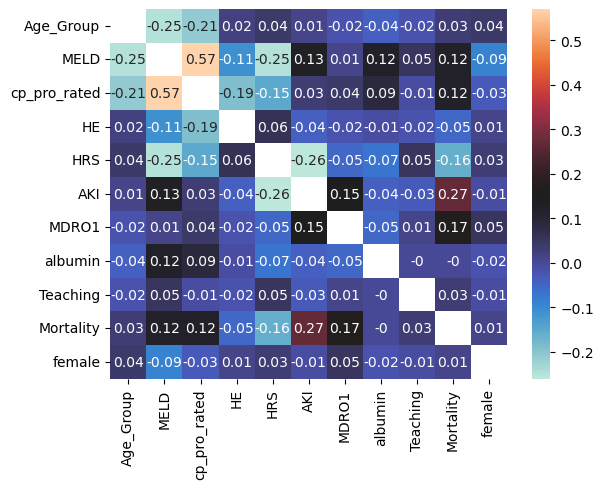

In [152]:
df_2.corr()
df_2.unstack().sort_values()

correlation_matrix = df_2.corr().round(2)
correlation_matrix *= 1 + np.diag(np.nan*np.ones(11))
sns.heatmap(data=correlation_matrix, annot=True, cmap="icefire");

In [153]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9572 entries, 2 to 12569
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age_Group   9572 non-null   float64
 1   HE          9572 non-null   float64
 2   HRS         9572 non-null   float64
 3   AKI         9572 non-null   float64
 4   MDRO1       9572 non-null   float64
 5   albumin     9572 non-null   int32  
 6   Teaching    9572 non-null   float64
 7   Mortality   9572 non-null   float64
 8   female      9572 non-null   int32  
 9   meld_group  9572 non-null   int32  
 10  cp_class    9572 non-null   int32  
dtypes: float64(7), int32(4)
memory usage: 1005.9 KB


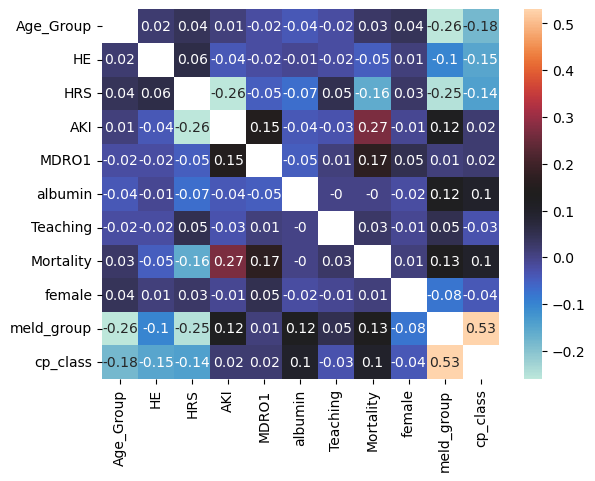

In [154]:
df_3.corr()
df_3.unstack().sort_values()

correlation_matrix = df_3.corr().round(2)
correlation_matrix *= 1 + np.diag(np.nan*np.ones(11))
sns.heatmap(data=correlation_matrix, annot=True, cmap="icefire");

# 2. Logistic Regression

### 2.1 Multivariate

In [155]:
df_3.head()

Age_Group   HE  HRS  AKI  MDRO1  albumin  Teaching  Mortality  female  \
2        4.0  4.0  4.0  1.0    0.0        0       0.0        0.0       1   
6        4.0  4.0  2.0  1.0    0.0        1       0.0        0.0       0   
7        2.0  4.0  4.0  1.0    0.0        1       0.0        1.0       1   
8        3.0  4.0  4.0  1.0    0.0        1       0.0        0.0       1   
9        1.0  4.0  4.0  0.0    0.0        1       1.0        0.0       0   

   meld_group  cp_class  
2           1         2  
6           3         3  
7           1         1  
8           1         2  
9           3         3

In [156]:
df_3['cp_class'].value_counts()

3    4939
2    3637
1     996
Name: cp_class, dtype: int64

In [158]:
model = sm.GLM.from_formula("Mortality ~ C(Age_Group, Treatment(reference=2.0)) + \
                                             C(HE, Treatment(reference=4.0)) + \
                                             C(HRS, Treatment(reference=4.0)) + \
                                             AKI + MDRO1 + albumin + female + Teaching + \
                                             C(meld_group, Treatment(reference=2)) + \
                                             C(cp_class, Treatment(reference=3))",
                            family=sm.families.Binomial(), data=df_3)
result = model.fit()
result.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Mortality   No. Observations:                 9572
Model:                            GLM   Df Residuals:                     9552
Model Family:                Binomial   Df Model:                           19
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4005.7
Date:                Fri, 14 Jun 2024   Deviance:                       8011.4
Time:                        10:29:28   Pearson chi2:                 9.35e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1100
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                        -2.8488      0.113    -25.242      0.000      -3.070      -2.628
C(Age_Group, Treatment(reference=2.0))[T.1.0]    -0.3445      0.082     -4.208      0.000      -0.505      -0.184
C(Age_Group, Treatment(reference=2.0))[T.3.0]     0.0561      0.079      0.706      0.480      -0.100       0.212
C(Age_Group, Treatment(reference=2.0))[T.4.0]     0.2517      0.080      3.133      0.002       0.094       0.409
C(HE, Treatment(reference=4.0))[T.1.0]           -0.2064      0.264     -0.781      0.435      -0.724       0.311
C(HE, Treatment(reference=4.0))[T.2.0]            0.2782      0.110      2.534      0.011       0.063       0.493
C(HE, Treatment(reference=4.0))[T.3.0]           -0.5652      0.264     -2.142      0.032      -1.082      -0.048
C(HRS, Treatment(reference=4.0))[T.1.0]           0.4784      0.214      2.234      0.026       0.059       0.898
C(HRS, Treatment(reference=4.0))[T.2.0]           0.4121      0.068      6.080      0.000       0.279       0.545
C(HRS, Treatment(reference=4.0))[T.3.0]          -0.0794      0.250     -0.317      0.751      -0.570       0.411
C(meld_group, Treatment(reference=2))[T.1]        0.2513      0.089      2.828      0.005       0.077       0.425
C(meld_group, Treatment(reference=2))[T.3]        0.3535      0.087      4.083      0.000       0.184       0.523
C(meld_group, Treatment(reference=2))[T.4]        0.6760      0.090      7.533      0.000       0.500       0.852
C(cp_class, Treatment(reference=3))[T.1]         -0.3847      0.116     -3.310      0.001      -0.612      -0.157
C(cp_class, Treatment(reference=3))[T.2]         -0.3331      0.070     -4.745      0.000      -0.471      -0.195
AKI                                               1.3513      0.065     20.682      0.000       1.223       1.479
MDRO1                                             0.8033      0.067     11.907      0.000       0.671       0.936
albumin                                          -0.0330      0.060     -0.554      0.580      -0.150       0.084
female                                            0.0819      0.059      1.396      0.163      -0.033       0.197
Teaching                                          0.2830      0.071      3.980      0.000       0.144       0.422
=================================================================================================================
"""

### 2.2 Univariate

#### Age

In [46]:
df_2 = df_2.loc[df_2['Gender'].isin(('Male', 'Female'))]

In [47]:
model = sm.GLM.from_formula("Mortality ~ C(Gender, Treatment(reference='Male'))",
                            family=sm.families.Binomial(), data=df_2)
result = model.fit()
result.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Mortality   No. Observations:                 9676
Model:                            GLM   Df Residuals:                     9674
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4601.7
Date:                Fri, 14 Jun 2024   Deviance:                       9203.4
Time:                        13:32:38   Pearson chi2:                 9.68e+03
No. Iterations:                     4   Pseudo R-squ. (CS):          0.0001410
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           -1.5214      0.034    -45.378      0.000      -1.587      -1.456
C(Gender, Treatment(reference='Male'))[T.Female]     0.0632      0.054      1.170      0.242      -0.043       0.169
====================================================================================================================
"""

#### HE

In [160]:
model = sm.GLM.from_formula("Mortality ~ C(HE, Treatment(reference=4.0))",
                            family=sm.families.Binomial(), data=df_3)
result = model.fit()
result.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Mortality   No. Observations:                 9572
Model:                            GLM   Df Residuals:                     9568
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4549.0
Date:                Fri, 14 Jun 2024   Deviance:                       9098.1
Time:                        10:30:21   Pearson chi2:                 9.57e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.002993
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 -1.5246      0.028    -54.780      0.000      -1.579      -1.470
C(HE, Treatment(reference=4.0))[T.1.0]     0.2125      0.247      0.859      0.390      -0.272       0.697
C(HE, Treatment(reference=4.0))[T.2.0]     0.5301      0.101      5.243      0.000       0.332       0.728
C(HE, Treatment(reference=4.0))[T.3.0]    -0.3512      0.248     -1.417      0.157      -0.837       0.135
==========================================================================================================
"""

#### HRS

In [161]:
model = sm.GLM.from_formula("Mortality ~  C(HRS, Treatment(reference=4.0))",
                            family=sm.families.Binomial(), data=df_3)
result = model.fit()
result.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Mortality   No. Observations:                 9572
Model:                            GLM   Df Residuals:                     9568
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4451.1
Date:                Fri, 14 Jun 2024   Deviance:                       8902.2
Time:                        10:30:22   Pearson chi2:                 9.57e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.02319
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  -1.7172      0.032    -53.805      0.000      -1.780      -1.655
C(HRS, Treatment(reference=4.0))[T.1.0]     0.9843      0.203      4.859      0.000       0.587       1.381
C(HRS, Treatment(reference=4.0))[T.2.0]     0.9102      0.061     14.961      0.000       0.791       1.029
C(HRS, Treatment(reference=4.0))[T.3.0]     0.4583      0.238      1.922      0.055      -0.009       0.926
===========================================================================================================
"""

#### AKI

In [162]:
model = sm.GLM.from_formula("Mortality ~  AKI",
                            family=sm.families.Binomial(), data=df_3)
result = model.fit()
result.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Mortality   No. Observations:                 9572
Model:                            GLM   Df Residuals:                     9570
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4209.1
Date:                Fri, 14 Jun 2024   Deviance:                       8418.3
Time:                        10:30:23   Pearson chi2:                 9.57e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.07135
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4387      0.053    -45.711      0.000      -2.543      -2.334
AKI            1.5223      0.062     24.488      0.000       1.400       1.644
==============================================================================
"""

#### MDRO

In [163]:
model = sm.GLM.from_formula("Mortality ~ MDRO1",
                            family=sm.families.Binomial(), data=df_3)
result = model.fit()
result.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Mortality   No. Observations:                 9572
Model:                            GLM   Df Residuals:                     9570
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4447.0
Date:                Fri, 14 Jun 2024   Deviance:                       8894.0
Time:                        10:30:24   Pearson chi2:                 9.57e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.02402
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.6878      0.031    -55.105      0.000      -1.748      -1.628
MDRO1          0.9977      0.063     15.820      0.000       0.874       1.121
==============================================================================
"""

#### Albumin

In [164]:
model = sm.GLM.from_formula("Mortality ~ albumin",
                            family=sm.families.Binomial(), data=df_3)
result = model.fit()
result.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Mortality   No. Observations:                 9572
Model:                            GLM   Df Residuals:                     9570
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4563.4
Date:                Fri, 14 Jun 2024   Deviance:                       9126.7
Time:                        10:30:26   Pearson chi2:                 9.57e+03
No. Iterations:                     4   Pseudo R-squ. (CS):          3.116e-06
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4863      0.044    -33.744      0.000      -1.573      -1.400
albumin       -0.0095      0.055     -0.173      0.863      -0.117       0.098
==============================================================================
"""

#### Gender

In [165]:
model = sm.GLM.from_formula("Mortality ~ female",
                            family=sm.families.Binomial(), data=df_3)
result = model.fit()
result.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Mortality   No. Observations:                 9572
Model:                            GLM   Df Residuals:                     9570
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4562.8
Date:                Fri, 14 Jun 2024   Deviance:                       9125.6
Time:                        10:30:27   Pearson chi2:                 9.57e+03
No. Iterations:                     4   Pseudo R-squ. (CS):          0.0001257
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5150      0.034    -45.060      0.000      -1.581      -1.449
female         0.0597      0.054      1.098      0.272      -0.047       0.166
==============================================================================
"""

#### MELD

In [166]:
model = sm.GLM.from_formula("Mortality ~ C(meld_group, Treatment(reference=2))",
                            family=sm.families.Binomial(), data=df_3)
result = model.fit()
result.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Mortality   No. Observations:                 9572
Model:                            GLM   Df Residuals:                     9568
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4477.2
Date:                Fri, 14 Jun 2024   Deviance:                       8954.3
Time:                        10:30:28   Pearson chi2:                 9.57e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01785
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                     -1.8435      0.059    -31.398      0.000      -1.959      -1.728
C(meld_group, Treatment(reference=2))[T.1]     0.0320      0.084      0.382      0.703      -0.132       0.196
C(meld_group, Treatment(reference=2))[T.3]     0.3904      0.078      4.977      0.000       0.237       0.544
C(meld_group, Treatment(reference=2))[T.4]     0.8377      0.075     11.210      0.000       0.691       0.984
==============================================================================================================
"""

#### Child-Pugh

In [167]:
model = sm.GLM.from_formula("Mortality ~ C(cp_class, Treatment(reference=3))",
                            family=sm.families.Binomial(), data=df_3)
result = model.fit()
result.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Mortality   No. Observations:                 9572
Model:                            GLM   Df Residuals:                     9569
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4511.8
Date:                Fri, 14 Jun 2024   Deviance:                       9023.7
Time:                        10:30:30   Pearson chi2:                 9.57e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01071
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   -1.2534      0.034    -36.615      0.000      -1.321      -1.186
C(cp_class, Treatment(reference=3))[T.1]    -0.6167      0.099     -6.213      0.000      -0.811      -0.422
C(cp_class, Treatment(reference=3))[T.2]    -0.5218      0.058     -8.960      0.000      -0.636      -0.408
============================================================================================================
"""

#### Teaching 

In [168]:
model = sm.GLM.from_formula("Mortality ~ Teaching",
                            family=sm.families.Binomial(), data=df_3)
result = model.fit()
result.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Mortality   No. Observations:                 9572
Model:                            GLM   Df Residuals:                     9570
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4559.5
Date:                Fri, 14 Jun 2024   Deviance:                       9119.0
Time:                        10:30:59   Pearson chi2:                 9.57e+03
No. Iterations:                     4   Pseudo R-squ. (CS):          0.0008088
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5288      0.030    -51.539      0.000      -1.587      -1.471
Teaching       0.1834      0.065      2.813      0.005       0.056       0.311
==============================================================================
"""